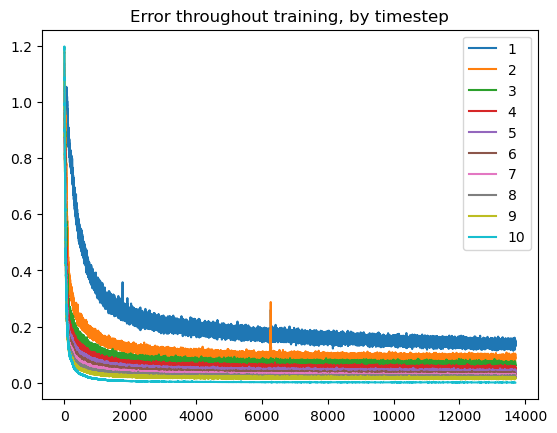

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# with open("mnist_generator_error_baseline.pkl", "rb") as f:
#     error = pickle.load(f)
with open("mnist_generator_error.pkl", "rb") as f:
    error = pickle.load(f)

plots = {}

for trainstep in range(len(error)):
    # each of these represents a batch from training.
    # `err` and `diffusionstep` are a pair of same-sized
    # tensors.
    err, diffusionstep = error[trainstep]
    diffusionstep = diffusionstep.view(-1)
    for (E, DS) in zip(err, diffusionstep):
        DS = int(DS.item())
        if DS not in plots:
            plots[DS] = {'x': [], 'y': []}
        plots[DS]['x'].append(trainstep)
        plots[DS]['y'].append(E.item())


for i in range(0, 10, 10):
    plt.title("Error throughout training, by timestep")
    for sub_i in range(i, i + 10):
        if (sub_i + 1) not in plots:
            # should only happen for plot 100
            continue
        xy = plots[sub_i + 1]
        x = np.array(xy['x'])
        y = np.array(xy['y'])
        moving_avg_k = 32
        y = np.convolve(np.array(y), np.ones(moving_avg_k), mode='valid') / moving_avg_k
        x = x[:len(y)]
        plt.plot(x, y, label=sub_i + 1)
        # print(sub_i, np.mean(y))
    plt.legend()
    plt.show()


# Sampling from the model

We'll just use regular DDPM sampling.

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noise_levels = 10
beta_min = 4e-4
beta_max = 0.02
betas = -(torch.cos(torch.linspace(0, np.pi, noise_levels, device=device)) - 1) / 2 * (beta_max - beta_min) + beta_min
alphabar = torch.cumprod(1 - betas, dim=0)
# scale to make alphabar = 0 at the end
orig_alphabar = alphabar
orig_alphabar0 = alphabar[0]
alphabar = alphabar - alphabar[-1]
alphabar = alphabar * orig_alphabar0 / alphabar[0]
# signal coefficients
sqrt_alphabar = torch.sqrt(alphabar)
# noise std. deviations
sqrt_one_minus_alphabar = torch.sqrt(1 - alphabar)
sigmas = sqrt_one_minus_alphabar
alphabarwith1 = torch.tensor([1, *alphabar])
rescaled_alpha = alphabarwith1[1:] / alphabarwith1[:-1]
rescaled_beta = 1 - rescaled_alpha


## Fixing the Noise Schedule

Following [this paper](https://arxiv.org/abs/2305.08891), we ensure zero terminal SNR.

We can also use offset noise but this is unnecessary for this dataset.


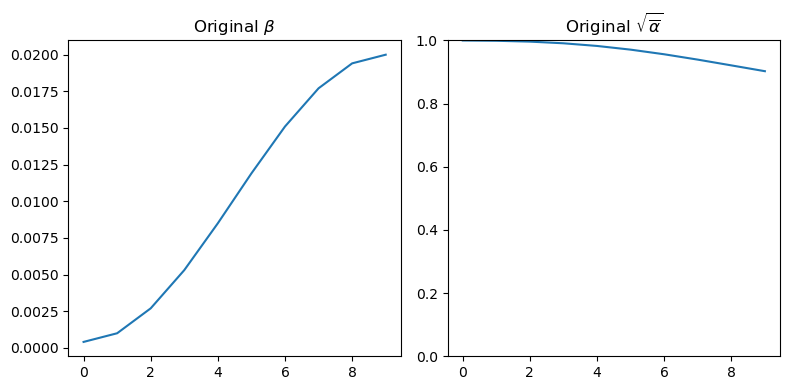

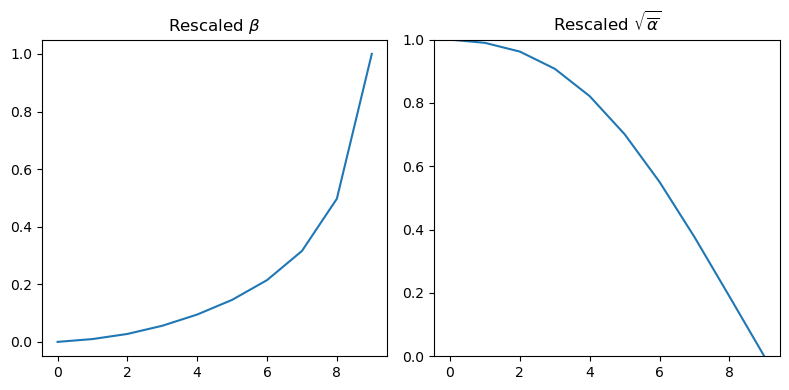

In [6]:
plt.rcParams['figure.figsize'] = [8, 4]

plt.subplot(1, 2, 1)
plt.title(r"Original $\beta$")
plt.plot(betas.detach().cpu())
plt.subplot(1, 2, 2)
plt.title(r"Original $\sqrt{\overline{\alpha}}$")
plt.plot(orig_alphabar.detach().cpu())
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title(r"Rescaled $\beta$")
plt.plot(rescaled_beta)
plt.subplot(1, 2, 2)
plt.title(r"Rescaled $\sqrt{\overline{\alpha}}$")
plt.plot(torch.cumprod(1 - rescaled_beta, dim=0).detach().cpu())
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [7]:
from denoising_unet import UNet

model = UNet(
    image_channels=1,
    n_channels=16,
    channel_multiples=[1, 2, 2, 4],
    is_attention=[False, False, True, True],
    n_blocks=2
).to(device)
model.load_state_dict(torch.load("mnist_generator.pth"))

Resolution: 0
DownBlock: 16 16
DownBlock: 16 16
Resolution: 1
DownBlock: 16 32
DownBlock: 32 32
Resolution: 2
DownBlock: 32 64
DownBlock: 64 64
Resolution: 3
DownBlock: 64 256
DownBlock: 256 256
UpBlock: 256 256
UpBlock: 256 256
UpBlock: 256 64
UpBlock: 64 64
UpBlock: 64 64
UpBlock: 64 32
UpBlock: 32 32
UpBlock: 32 32
UpBlock: 32 16
UpBlock: 16 16
UpBlock: 16 16
UpBlock: 16 16


<All keys matched successfully>

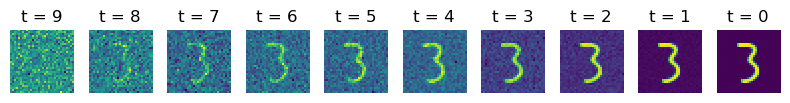

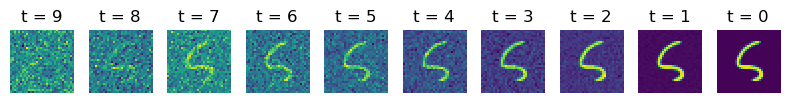

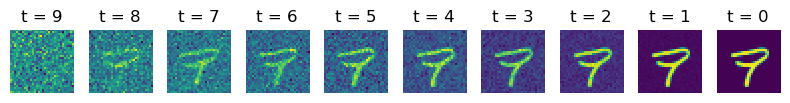

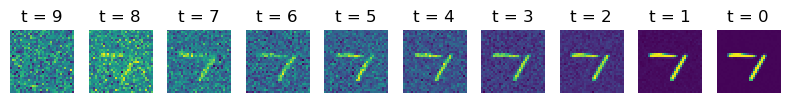

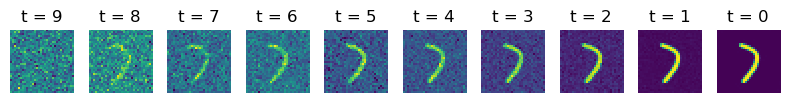

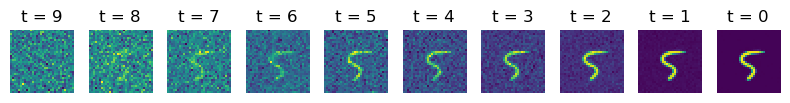

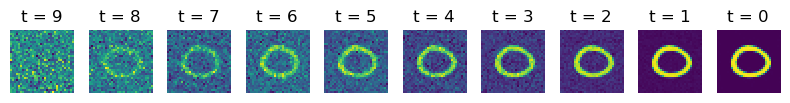

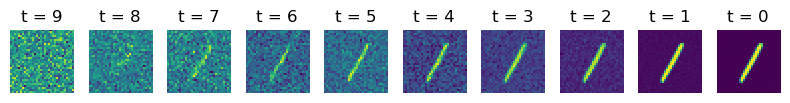

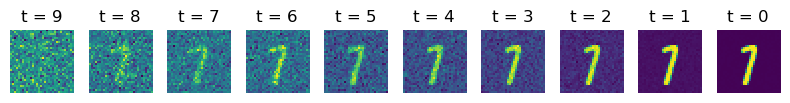

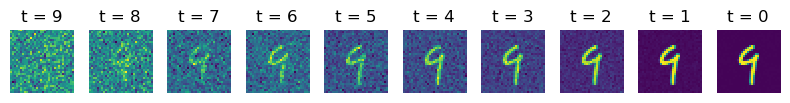

In [22]:
for shot in range(10):
    # Start with random noise
    sample = torch.randn(1, 32, 32, device=device, dtype=torch.float)
    
    samples = [sample]
    
    num_timesteps = len(sigmas)
    for t in reversed(range(9)):
        # choose previous sample
        alpha_t = rescaled_alpha[t]
        beta_t = rescaled_beta[t]
        alphabar_t = alphabar[t]
    
        t_tensor = torch.tensor([t + 1], device=device, dtype=torch.float)
        for i in range(5):
            sample_tensor = sample.unsqueeze(0)
            with torch.no_grad():
                predicted_noise = model(sample_tensor, t_tensor)[0]
        
                # \mu_{t} tilde
                mut_tilde = torch.rsqrt(alpha_t) * (sample - (1 - alpha_t) * torch.rsqrt(1 - alphabar_t) * predicted_noise)
                
                if t > 0:
                    # variance of the prediction for the previous step
                    # when t = 0, the variance is 0, as we are theoretically
                    # predicting the original sample itself
                    # \beta_{t} tilde
                    betat_tilde = 1/((alpha_t / beta_t) + 1/(1 - alphabar[t - 1]))
                    resample_noise = torch.randn_like(sample)
                    sample = mut_tilde + torch.sqrt(betat_tilde) * resample_noise
                else:
                    sample = mut_tilde
    
        samples.append(sample)
    
    denormalize = lambda sample: ((sample + 1) / 2).permute(1, 2, 0).detach().cpu().numpy()
    
    for i, sample in enumerate(samples):
        t = len(samples) - i - 1
        plt.subplot(1, len(samples), i + 1)
        plt.title("t = " + str(t))
        plt.imshow(denormalize(sample))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
